[View in Colaboratory](https://colab.research.google.com/github/planewave/coherent_receiver_with_CNN/blob/master/cfo_v3.ipynb)

CFO recovery
training with synthetic data

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
from torch import nn
#import torch.utils.data as Data
import numpy as np
#from matplotlib import pyplot as plt
#%% data gen
CUDA = True
M = 4
PI = 3.1416
LEN = 32
DATA_NUM = 5000
# BATCH_SIZE = 200
LR = 5e-4 # learning rate
dtype = torch.float


In [0]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 8, 3),
            nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Conv1d(8, 8, 3),
#             nn.ReLU(),
            )

        self.lin = nn.Linear(32, 1)

    def forward(self, x_in):
        cnn_out = self.cnn(x_in)
        cfo = self.lin(cnn_out.view(cnn_out.size(0), -1))
        return cfo

net = NET()
if CUDA:
    cuda = torch.device('cuda:0')
    net.cuda()
#     data_rec = data_rec.cuda()
#     offset = offset.cuda()
    
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

In [33]:
net(data_rec).shape

torch.Size([5000, 1])

In [36]:
for epoch in range(3000):
    data = np.random.randint(0, M, [DATA_NUM, 1, LEN])
    data_phase = (2*data-(M-1))*PI/M
    noise = 0.3*np.random.randn(DATA_NUM, 1, LEN)
    offset_np = np.random.rand(DATA_NUM, 1, 1)*0.8-0.4
    data_rec_np = data_phase+offset_np+noise
    data_rec = torch.tensor(data_rec_np, dtype=dtype).cuda()
    offset =  torch.tensor(offset_np, dtype=dtype).view(-1, 1).cuda() 

    y_est = net(data_rec)
    loss = loss_func(y_est, offset)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%500==0:
        print("epoch = ",epoch, "; loss = %7.2e"% loss.item())

epoch =  0 ; loss = 6.90e-03
epoch =  500 ; loss = 6.78e-03
epoch =  1000 ; loss = 6.72e-03
epoch =  1500 ; loss = 6.93e-03
epoch =  2000 ; loss = 6.40e-03
epoch =  2500 ; loss = 6.67e-03


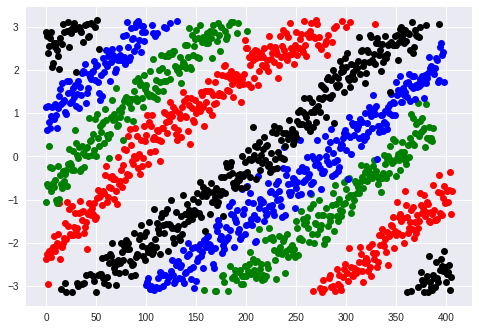

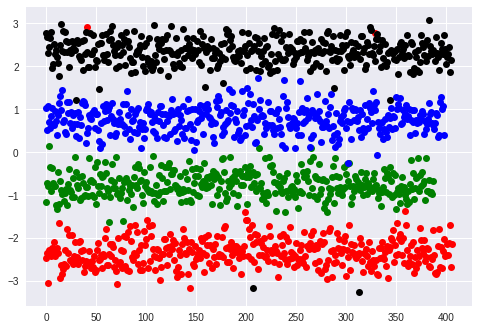

In [45]:
#%% test with time varing cfo
from matplotlib import pyplot as plt
FRM_NUM = 50
DATA_NUM2 = 1 # keep as 1
len_ts = LEN*FRM_NUM
   
data_ts = np.random.randint(0, M, [DATA_NUM2, 1, int(len_ts)])
phase_ts = (2*data_ts-(M-1))*PI/M
noise = 0.3*np.random.randn(DATA_NUM2, 1, int(len_ts))
offset_ts = np.linspace(0, len_ts/200, len_ts)+0.20*np.sin(np.arange(len_ts)/300)

# noise = 0
# offset_ts = 0
rec_ts = (phase_ts+offset_ts+noise+PI)%(2*PI)-PI
rec_pt = torch.tensor(rec_ts, dtype=dtype).cuda()
# plt.plot(rec_ts[0,0,0:1000], 'ro')
# plt.plot(rec_ts[0,0,0::], 'ro')
plt.plot(rec_ts.squeeze()[data_ts.squeeze()==0], 'ro', 
        rec_ts.squeeze()[data_ts.squeeze()==1], 'go',
        rec_ts.squeeze()[data_ts.squeeze()==2], 'bo',
        rec_ts.squeeze()[data_ts.squeeze()==3], 'ko',)

plt.show()
phase_pt = torch.zeros(1).cuda()

recover = torch.zeros_like(rec_pt.squeeze())
# step = 0
# frame = rec_pt[:, :, LEN*step:LEN*(step+1)]-phase_pt
for step in range(FRM_NUM):
    frame = (rec_pt[:, :, LEN*step:LEN*(step+1)]-phase_pt+PI)%(2*PI)-PI
    cfo = net(frame)
    phase_pt = phase_pt+cfo
#     print('%6.4f'%cfo.item())
    recover[LEN*step:LEN*(step+1)] = frame-cfo
    
data_plot = recover.cpu().detach().numpy()
plt.plot(data_plot[data_ts.squeeze()==0], 'ro', 
        data_plot[data_ts.squeeze()==1], 'go',
        data_plot[data_ts.squeeze()==2], 'bo',
        data_plot[data_ts.squeeze()==3], 'ko',)
plt.show()

In [0]:
from google.colab import files
# save

torch.save(net.state_dict(), 'net.pt')

# load

# the_model = TheModelClass()
# the_model.load_state_dict(torch.load('net.pt'))
files.download('net.pt')